# Data Collection

In order to begin analyzing stocks we first need to collect data to analyze. We will do this by scraping a specified timeframe of stock information for a specified number of stocks.


## Getting Started
To get started, we must import some libraries:

In [1]:
import sys
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
print("======================")


import yfinance as yf
import pandas as pd

print ("Successfully imported libraries")

Successfully imported libraries


We will begin by specifying a list of tickers we want to scrape:

In [2]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

From here, we have to define some options:

- Interval: This represents the frequency we want to get stock data
- Time Frame (2 options):
    - A)
        - Period: This represents a timeframe in english (1m, 5m, 1d, 1y, ...)
    - B)
        - Start Date: This is the starting date for data scraping
        - End Date: This is the ending date for data scraping

In [3]:
period = '10y'
start_date = None
end_date = None
interval = "1d"

Just a quick check to ensure variables are instantiated correctly:

In [4]:
if tickers == None:
    raise Exception("You must specify a list of tickers to scrape")

if period == None and start_date == None and end_date == None:
            raise Exception("You must specify one timeframe in order to scrape")
        
if period == None and (start_date == None or end_date == None):
    raise Exception("You must specify both ends of the timeframe in order to scrape")

if period not in ['1d','5d','1mo','3mo','6mo','1y','2y','5y','10y','ytd','max']:
    raise Exception("Please input a valid period")

if interval not in ['1m','2m','5m','15m','30m','60m','90m','1h','1d','5d','1wk','1mo','3mo']:
    raise Exception("Please input a valid time interval")

if period != None and (start_date != None or end_date != None):
    raise Exception("You can only specify one type of timeframe in order to scrape")

print("Passed!")

Passed!


## Scraping Data
Now that we have defined the scraping parameters, we can actually begin to scrape. We do this by calling the YFinance download method for each stock. However, we have to consider two cases:
- We are using period
- We are using start/end dates


In [5]:
ticker_string = ' '.join(tickers) #convert from list to space-separated string
print(f"Ticker String: \n{ticker_string}")

if period != None: #if using period
    data = yf.download(
        ticker_string,
        period = period,
        interval = interval,
        group_by = 'ticker',
        threads = True
    )
else:
    data = yf.download( #if using start/end dates
        ticker_string,
        start = start_date, 
        end = end_date,
        interval = interval,
        group_by = 'ticker',
        threads = True
    )


data = data.drop([(i, 'Close') for i in tickers], axis=1)
data = data.rename({"Adj Close": "Close"}, axis=1)


data.head()

Ticker String: 
AMZN TSLA BABA HD TM NKE MCD LOW SBUX JD PDD BKNG GM MELI TJX NIO F LULU HMC CMG
[*********************100%***********************]  20 of 20 completed


TSLA                                BABA                        \
             Open   High    Low  Close    Volume Open High Low Close Volume   
Date                                                                          
2011-11-08  6.274  6.400  6.144  6.368   5839500  NaN  NaN NaN   NaN    NaN   
2011-11-09  6.174  6.298  6.060  6.176   4768500  NaN  NaN NaN   NaN    NaN   
2011-11-10  6.188  6.300  6.130  6.266   3736500  NaN  NaN NaN   NaN    NaN   
2011-11-11  6.380  6.900  6.114  6.728  19341500  NaN  NaN NaN   NaN    NaN   
2011-11-14  6.600  6.708  6.524  6.644   6628500  NaN  NaN NaN   NaN    NaN   

            ...       LULU                                            \
            ...       Open       High        Low      Close   Volume   
Date        ...                                                        
2011-11-08  ...  55.610001  57.930000  55.250000  57.459999  3787400   
2011-11-09  ...  55.939999  56.470001  54.099998  54.480000  2800900   
2011-11-10  ...  55.299999  55.610001  53.500000  53.980000  1620200   
2011-11-11  ...  54.549999  55.049999  53.340000  53.950001  2117600   
2011-11-14  ...  53.900002  54.630001  52.580002  52.709999  2536200   

                  MCD                                            
                 Open       High        Low      Close   Volume  
Date                                                             
2011-11-08  94.959999  95.449997  93.839996  71.109070  7195500  
2011-11-09  93.410004  93.959999  92.349998  69.643311  6666000  
2011-11-10  93.279999  93.489998  92.589996  70.101822  4189400  
2011-11-11  93.930000  94.949997  93.860001  71.229340  4425500  
2011-11-14  94.349998  94.800003  93.860001  70.703171  3232200  

[5 rows x 100 columns]

# Adding Technical Indicators

Using the [TA-Lib](https://mrjbq7.github.io/ta-lib/) package, we can broadcast technical indicators across the time series into their own dataframe columns

In [6]:
import talib
!{sys.executable} -m pip install TA-Lib

def computeRSI(df):
    return talib.RSI(df["Close"], timeperiod=14)

def computeUltimateOscillator(df):
    return talib.ULTOSC(df["High"], df["Low"], df["Close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)

def computeBollingerBands(df):
    upperband, middleband, _ = talib.BBANDS(df["Close"], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    return (upperband - middleband) / df["Close"] # need to normalize so value is not dependent on share price

def computeChaikinOscillator(df):
    return talib.ADOSC(df["High"], df["Low"], df["Close"], df["Volume"], fastperiod=3, slowperiod=10)

def computeNATR(df):
    return talib.NATR(df["High"], df["Low"], df["Close"], timeperiod=14)

def computeSMA(df, window):
    return talib.SMA(df["Close"], timeperiod=window) / df["Close"] # need to normalize so value is not dependent on share price

def computeSAR(df):
    return talib.SAR(df["High"], df["Low"], acceleration=0, maximum=0) / df["Close"] # need to normalize so value is not dependent on share price

def computeWilliamsR(df):
    return talib.WILLR(df["High"], df["Low"], df["Close"], timeperiod=14)

def computeAPO(df):
    return talib.APO(df["Close"], fastperiod=12, slowperiod=26, matype=0) / df["Close"]# need to normalize so value is not dependent on share price

def computeROC(df, window):
    return talib.ROCP(df["Close"], timeperiod=window) 


Now, we can apply these functions across the collected timeseries

In [7]:
for ticker in tickers:
    df = data[ticker]
    data[ticker, 'RSI'] = computeRSI(df)
    data[ticker, 'Ultimate'] = computeUltimateOscillator(df)
    data[ticker, 'BandRadius'] = computeBollingerBands(df)
    data[ticker, 'Chaikin'] = computeChaikinOscillator(df)
    data[ticker, 'NATR'] = computeNATR(df)
    data[ticker, 'SMA_5'] = computeSMA(df, 5)
    data[ticker, 'SMA_20'] = computeSMA(df, 20)
    data[ticker, 'SMA_100'] = computeSMA(df, 100)
    data[ticker, 'SAR'] = computeSAR(df)
    data[ticker, 'Williams%R'] = computeWilliamsR(df)
    data[ticker, 'APO'] = computeAPO(df)
    data[ticker, 'ROC_5'] = computeROC(df, 5)
    data[ticker, 'ROC_20'] = computeROC(df, 20)
    data[ticker, 'ROC_100'] = computeROC(df, 100)

data.head(100)

TSLA                                BABA                        \
             Open   High    Low  Close    Volume Open High Low Close Volume   
Date                                                                          
2011-11-08  6.274  6.400  6.144  6.368   5839500  NaN  NaN NaN   NaN    NaN   
2011-11-09  6.174  6.298  6.060  6.176   4768500  NaN  NaN NaN   NaN    NaN   
2011-11-10  6.188  6.300  6.130  6.266   3736500  NaN  NaN NaN   NaN    NaN   
2011-11-11  6.380  6.900  6.114  6.728  19341500  NaN  NaN NaN   NaN    NaN   
2011-11-14  6.600  6.708  6.524  6.644   6628500  NaN  NaN NaN   NaN    NaN   
...           ...    ...    ...    ...       ...  ...  ...  ..   ...    ...   
2012-03-27  7.432  7.990  7.406  7.588  12696000  NaN  NaN NaN   NaN    NaN   
2012-03-28  7.556  7.688  7.422  7.570   4775000  NaN  NaN NaN   NaN    NaN   
2012-03-29  7.638  7.638  7.406  7.466   3982000  NaN  NaN NaN   NaN    NaN   
2012-03-30  7.504  7.588  7.336  7.448   4432000  NaN  NaN NaN   NaN    NaN   
2012-04-02  7.466  7.594  7.306  7.316   5143000  NaN  NaN NaN   NaN    NaN   

            ...       CMG                                                     \
            ...      NATR     SMA_5    SMA_20   SMA_100       SAR Williams%R   
Date        ...                                                                
2011-11-08  ...       NaN       NaN       NaN       NaN       NaN        NaN   
2011-11-09  ...       NaN       NaN       NaN       NaN  1.029744        NaN   
2011-11-10  ...       NaN       NaN       NaN       NaN  1.051737        NaN   
2011-11-11  ...       NaN       NaN       NaN       NaN  1.032287        NaN   
2011-11-14  ...       NaN  1.013754       NaN       NaN  1.048038        NaN   
...         ...       ...       ...       ...       ...       ...        ...   
2012-03-27  ...  1.404993  0.994765  0.959437       NaN  0.711963 -15.142728   
2012-03-28  ...  1.439195  0.999691  0.965916       NaN  0.714133 -20.964122   
2012-03-29  ...  1.437112  0.999615  0.967851       NaN  0.713233 -19.249471   
2012-03-30  ...  1.459708  1.007072  0.976742       NaN  0.717703 -28.443432   
2012-04-02  ...  1.488503  1.003098  0.978846  0.863103  0.717017 -28.250379   

                                                  
                 APO     ROC_5    ROC_20 ROC_100  
Date                                              
2011-11-08       NaN       NaN       NaN     NaN  
2011-11-09       NaN       NaN       NaN     NaN  
2011-11-10       NaN       NaN       NaN     NaN  
2011-11-11       NaN       NaN       NaN     NaN  
2011-11-14       NaN       NaN       NaN     NaN  
...              ...       ...       ...     ...  
2012-03-27  0.026489  0.020588  0.075033     NaN  
2012-03-28  0.027705  0.009565  0.076547     NaN  
2012-03-29  0.028483  0.005955  0.067293     NaN  
2012-03-30  0.029380  0.005993  0.059865     NaN  
2012-04-02  0.028758 -0.014834  0.064685     NaN  

[100 rows x 380 columns]

At this point, we have a 3D nested dataframe, split by tickers and then by columns. To put this data in CSV files, we will create a CSV file for each ticker containing the relevant information.

In [13]:
import os

for ticker in tickers:
    print(f"Saving data for {ticker}")
    
    tickerdata = data[ticker].dropna() #remove nan values
    if not os.path.exists("data"):
        os.mkdir("data")
    tickerdata.to_csv(f'./data/{ticker}.csv') #write to csv file

print("======================")
print("Saved stocks to CSV files. Take a look inside /data for them.")

Saving data for AMZN
Saving data for TSLA
Saving data for BABA
Saving data for HD
Saving data for TM
Saving data for NKE
Saving data for MCD
Saving data for LOW
Saving data for SBUX
Saving data for JD
Saving data for PDD
Saving data for BKNG
Saving data for GM
Saving data for MELI
Saving data for TJX
Saving data for NIO
Saving data for F
Saving data for LULU
Saving data for HMC
Saving data for CMG
Saved stocks to CSV files. Take a look inside /data for them.


<IPython.core.display.Javascript object>


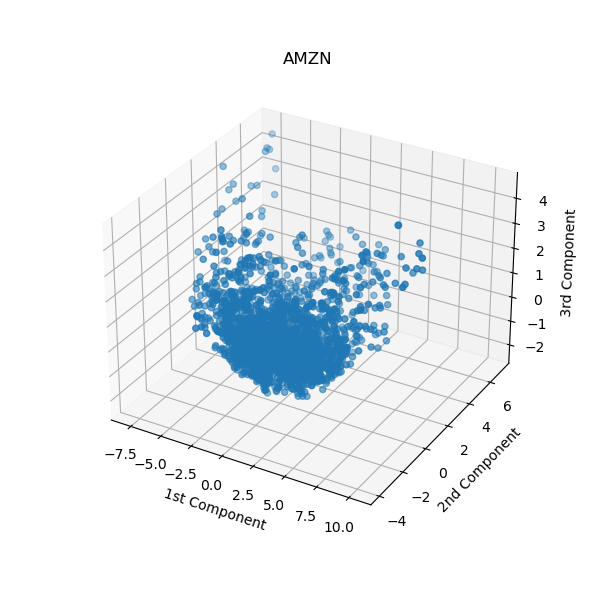

<IPython.core.display.Javascript object>


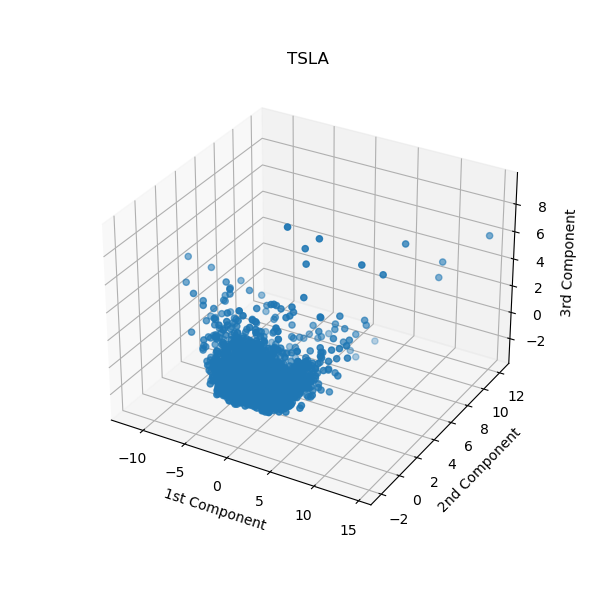

<IPython.core.display.Javascript object>


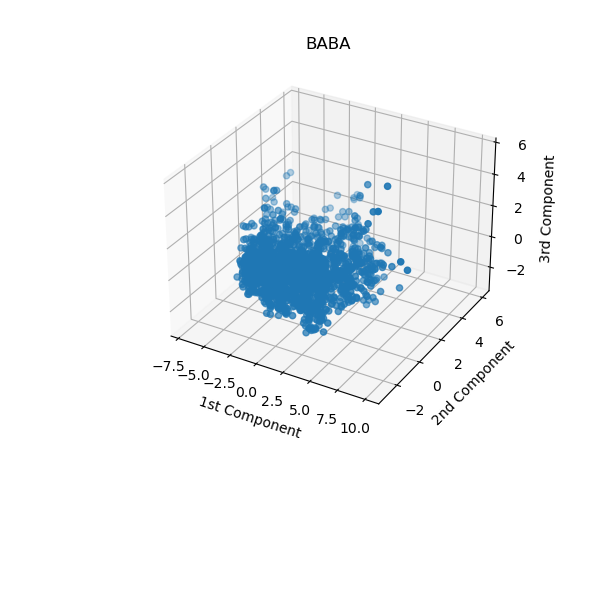

<IPython.core.display.Javascript object>


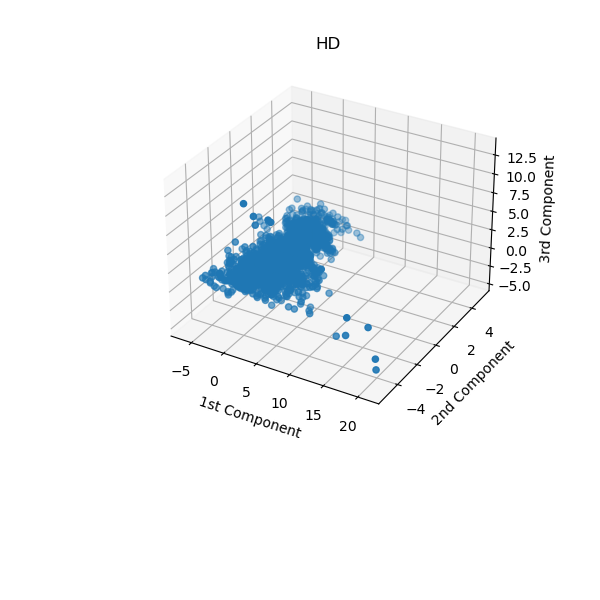

<IPython.core.display.Javascript object>


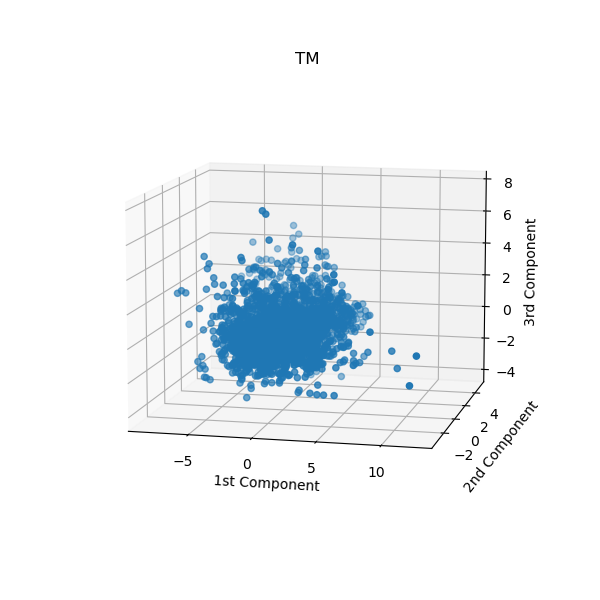

<IPython.core.display.Javascript object>


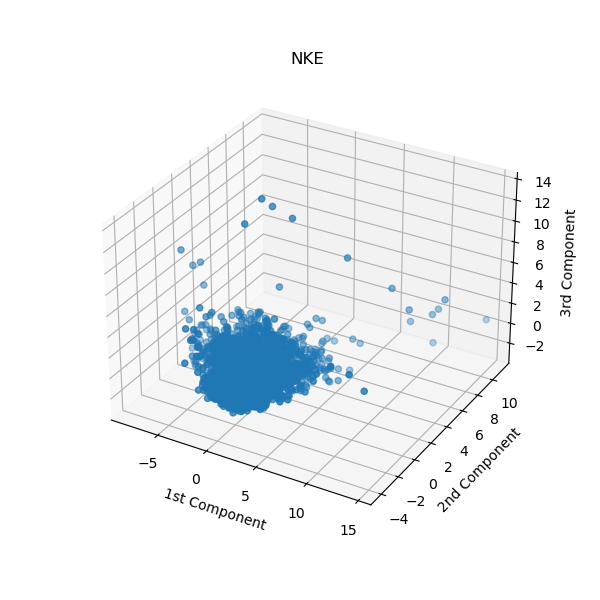

<IPython.core.display.Javascript object>


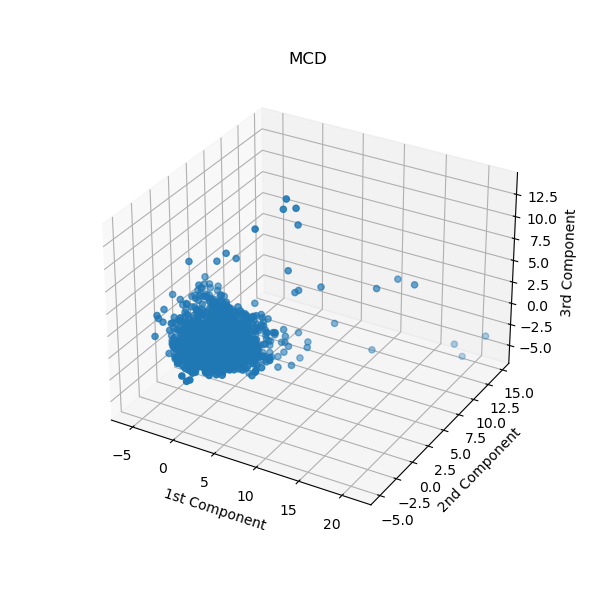

<IPython.core.display.Javascript object>


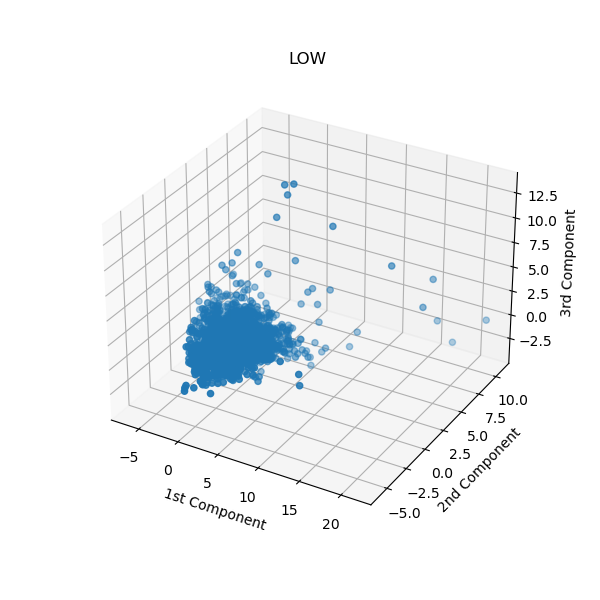

<IPython.core.display.Javascript object>


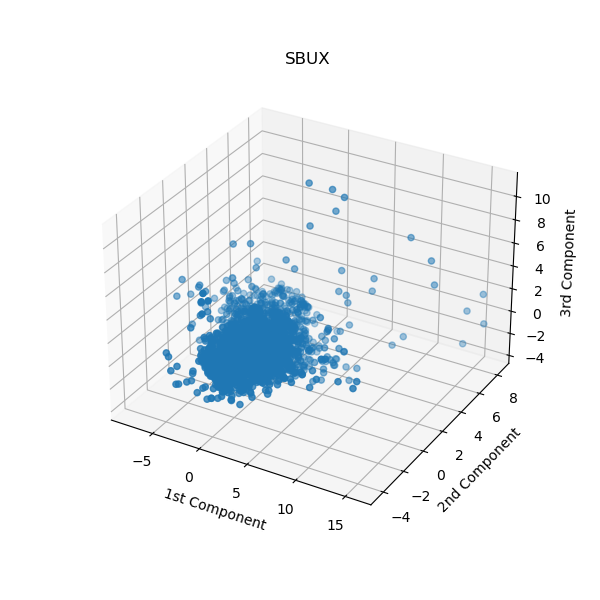

<IPython.core.display.Javascript object>


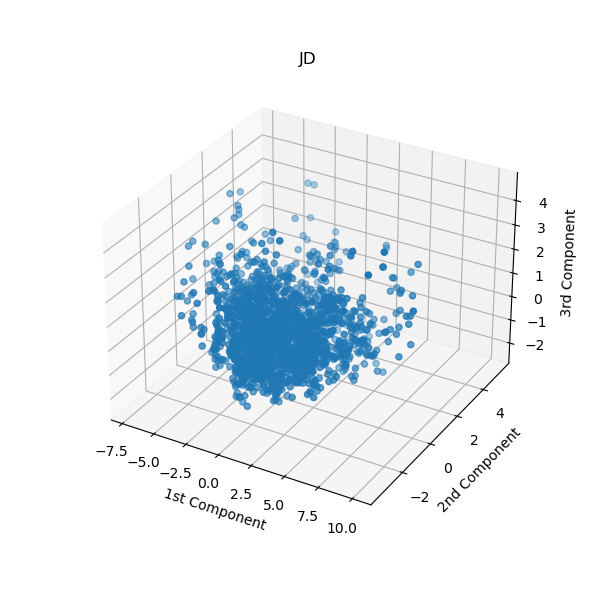

<IPython.core.display.Javascript object>


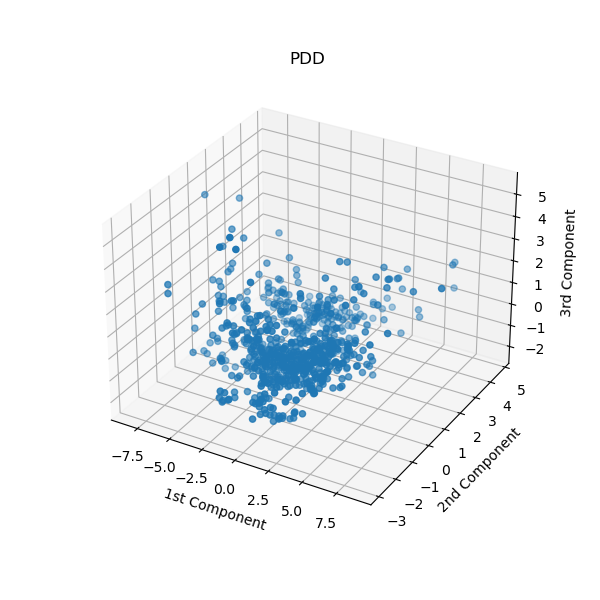

<IPython.core.display.Javascript object>


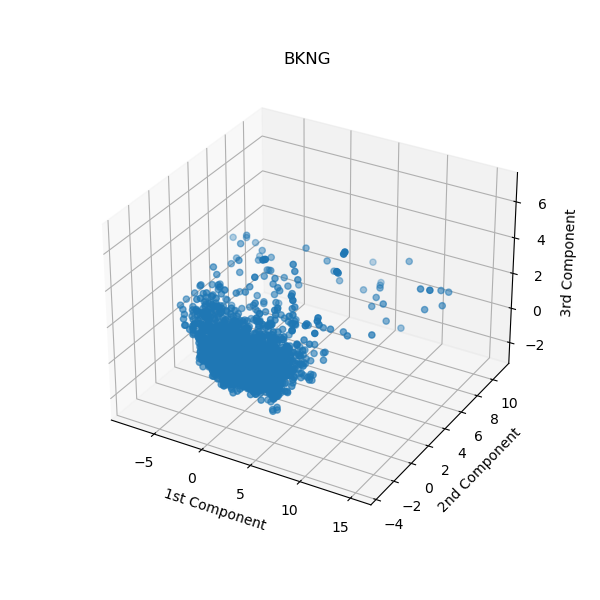

<IPython.core.display.Javascript object>


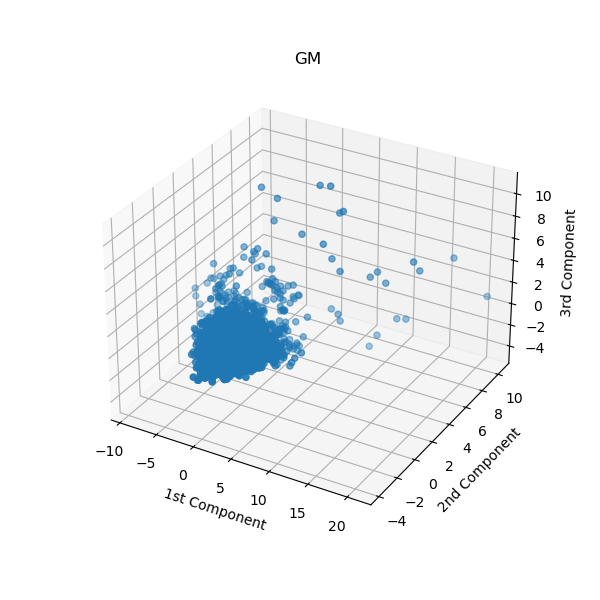

<IPython.core.display.Javascript object>


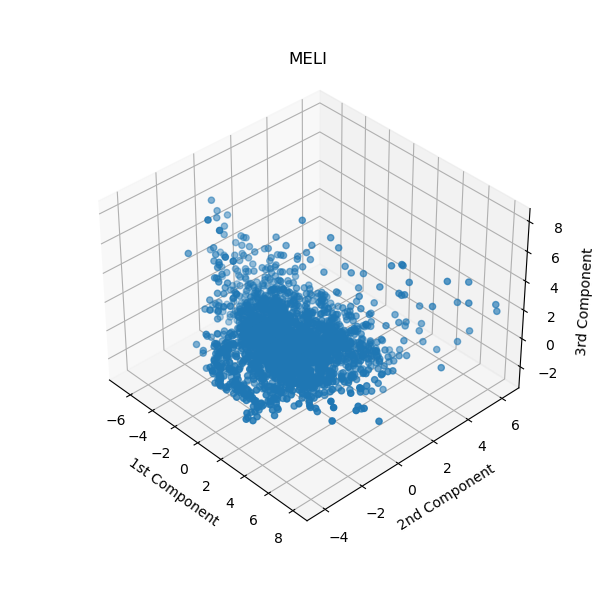

<IPython.core.display.Javascript object>


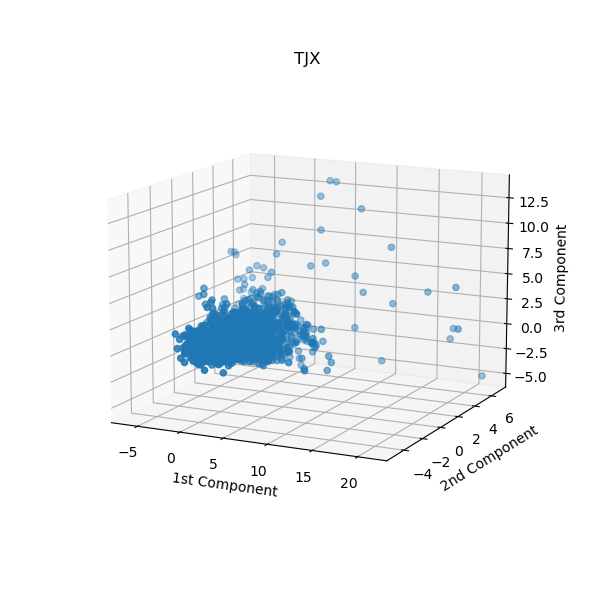

<IPython.core.display.Javascript object>


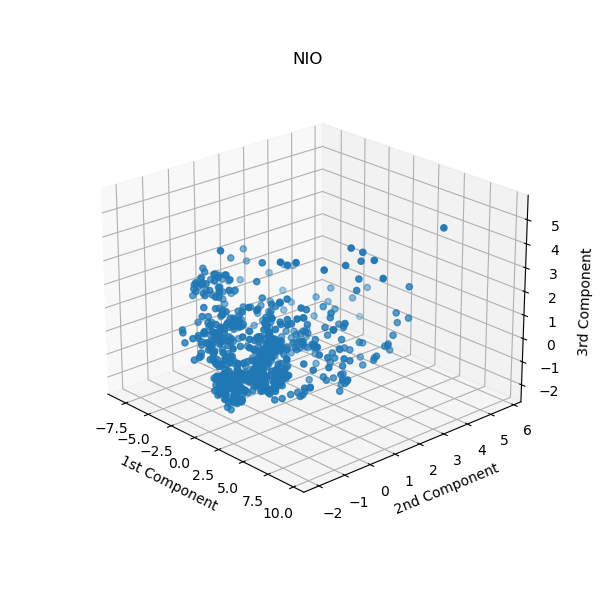

<IPython.core.display.Javascript object>


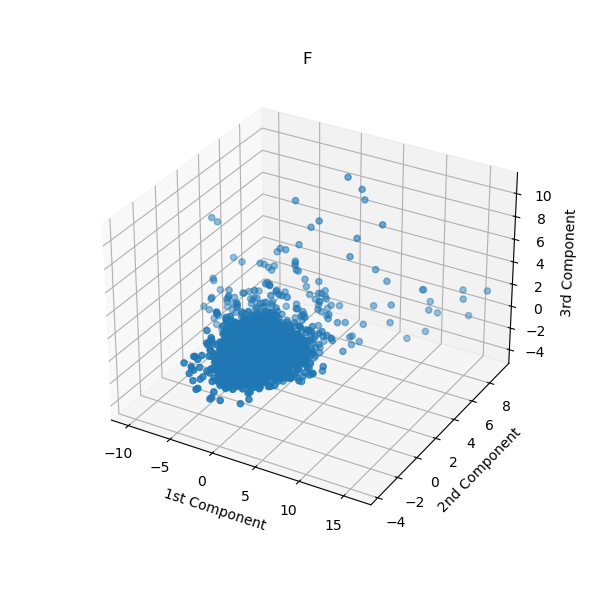

<IPython.core.display.Javascript object>


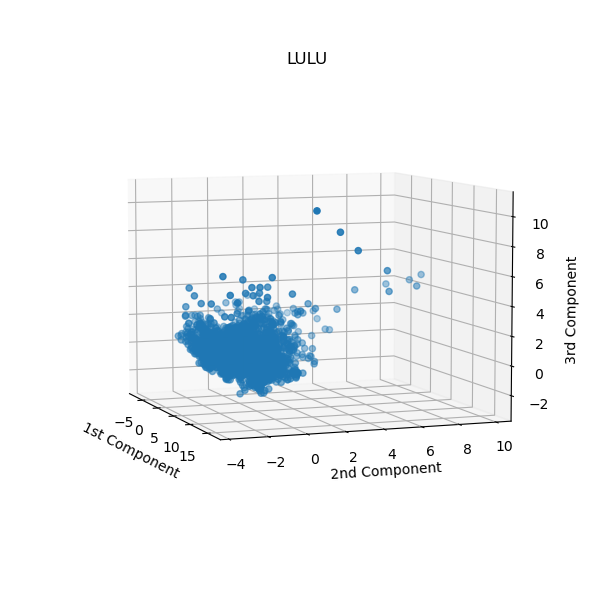

<IPython.core.display.Javascript object>


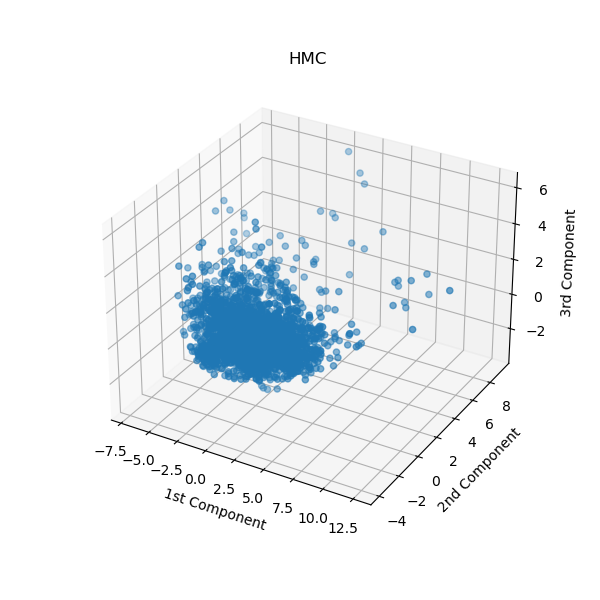

<IPython.core.display.Javascript object>


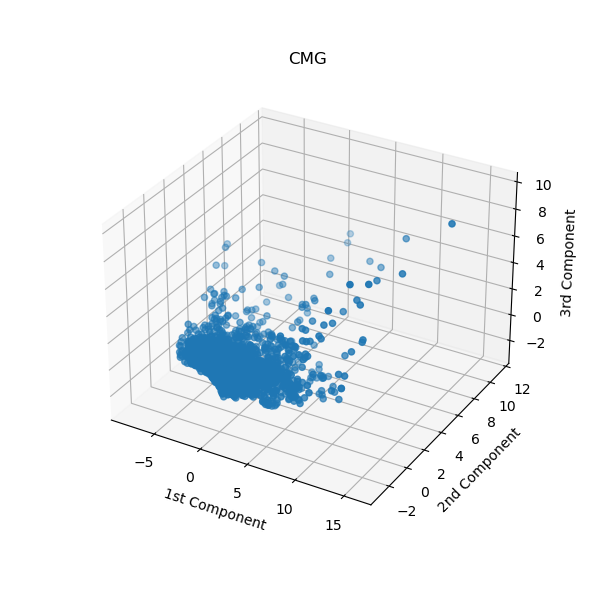

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

for ticker in tickers:
    # read in data from csv
    data = pd.read_csv(f'./data/{ticker}.csv')

    # generate matrix with technical indicators (features) as columns
    features = data.to_numpy()[:, 6:]

    # normalize each feature
    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    # project the data along the first 3 principal components
    pca = PCA(n_components=3)
    X_proj = pca.fit_transform(X)

    # plot the transformed data
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2])
    ax.set_xlabel("1st Component")
    ax.set_ylabel("2nd Component")
    ax.set_zlabel("3rd Component")
    plt.title(ticker)

    fig.set_size_inches(6, 6)
    if not os.path.exists("figs"):
            os.mkdir("figs")
    plt.savefig('./figs/' + ticker + '_pca.png', dpi=200)